# Import packages

In [1]:
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings(('ignore'))


import pandas as pd
import numpy as np


from modules.Utils.utils import loadFromDB, computeFutureLinearRegression, strategyTester
from modules.Utils.indicators import computeRSI_VWAP

# Get Data

In [2]:
SYMBOL= 'BTC'
df =loadFromDB(SYMBOL,'1h')
df = computeRSI_VWAP(df,17,25)
df.dropna(inplace=True)
print(df.shape)
df.head()

(20810, 7)


,Open,High,Low,Close,Volume,Timestamp,RSI_VWAP
Date,,,,,,,
2020-06-01 16:00:00,9548.18,9610.00,9536.99,9584.28,3086.584917,1591027200,100.0
2020-06-01 17:00:00,9584.29,9592.59,9563.26,9575.29,1176.977333,1591030800,100.0
2020-06-01 18:00:00,9575.29,9587.01,9555.24,9579.70,996.499709,1591034400,100.0
2020-06-01 19:00:00,9579.97,9612.76,9561.29,9572.48,1688.498467,1591038000,100.0
2020-06-01 20:00:00,9572.50,9688.00,9558.57,9668.71,3151.002213,1591041600,100.0


Period : [2020-06-01 16:00:00] -> [2022-10-16 17:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 1980.61 $
Performance vs US Dollar : 98.06 %
Buy and Hold Performence : 99.76 %
Performance vs Buy and Hold : -1.7 %
Best trade : +27.12 %, the 2021-01-09 17:00:00
Worst trade : -33.89 %, the 2021-05-25 21:00:00
Worst drawBack : -43.0 %
Total fees :  326.84 $

----- Trades Informations -----
Total trades on period : 108
Number of positive trades : 61
Number of negative trades :  47
Trades win rate ratio : 56.48 %
Average trades performance : 0.95 %
Average positive trades : 4.75 %
Average negative trades : -3.97 %

----- Plot -----


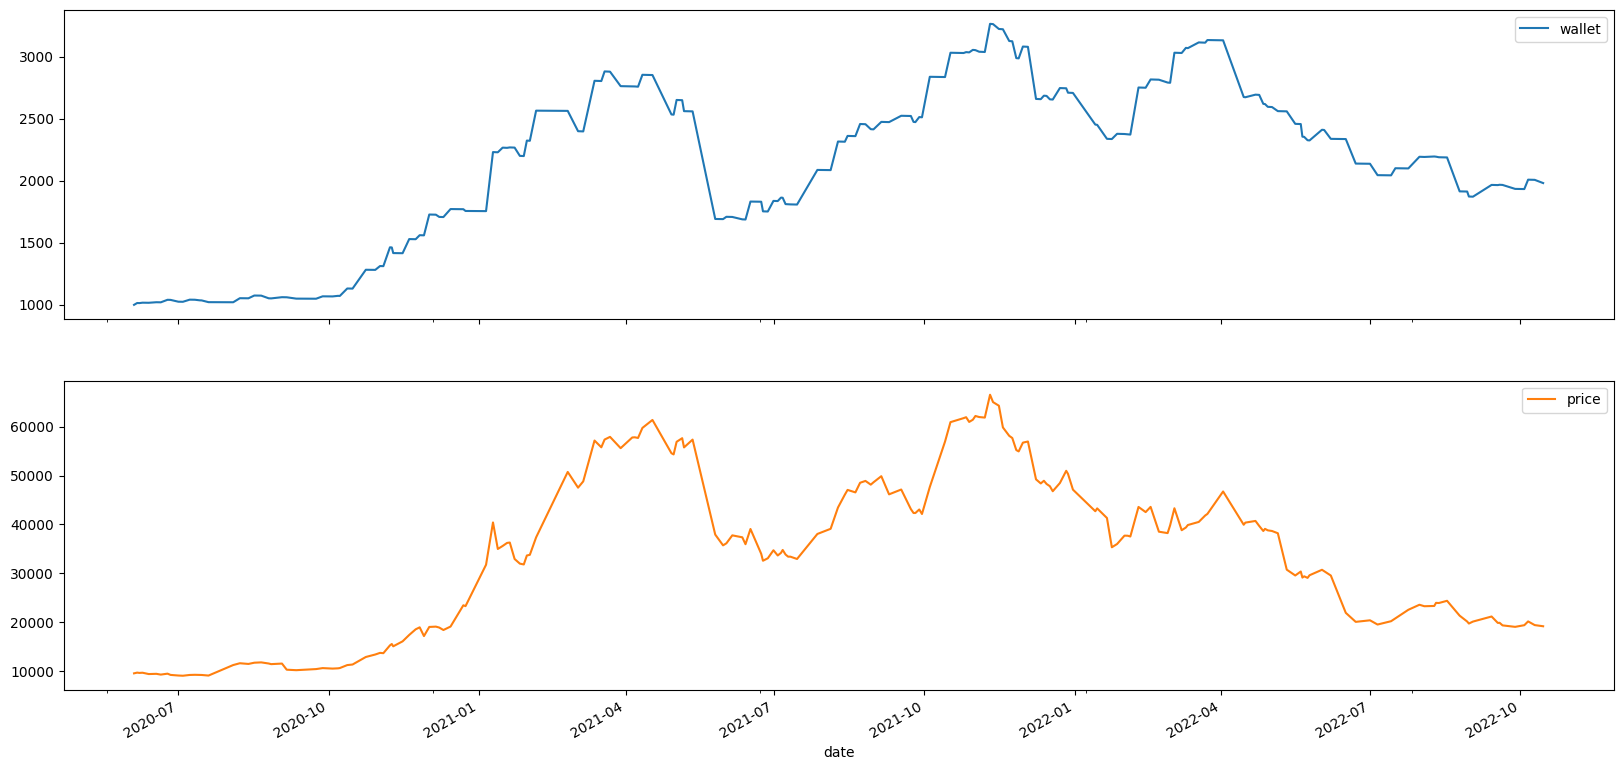

In [3]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.RSI_VWAP>19 and previous_row.RSI_VWAP<19 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.RSI_VWAP<80 and previous_row.RSI_VWAP>80 else False

strategyTester(df,buyCondition,sellCondition,equity=1000)